<a href="https://colab.research.google.com/github/YasasTL/Chords-prediction/blob/main/Chords_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
a


import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split

# Define the chords and their corresponding labels
chords = ["Am", "Bb", "Bdim", "C", "Dm", "Em", "F", "G"]
labels = {chord: index for index, chord in enumerate(chords)}

# Function to extract MFCCs from an audio file
def extract_mfcc(audio_file, n_mfcc):
    signal, sr = librosa.load(audio_file, sr=22050)
    # Apply FFT to obtain the spectrum
    n_fft = 2048
    spectra = np.abs(librosa.stft(signal, n_fft=n_fft))
    # Convert to log amplitude spectrum
    log_amplitude_spectrum = librosa.amplitude_to_db(spectra)
    # Apply mel filter bands
    n_mels = 40
    mel_filter_banks = librosa.filters.mel(sr=22050, n_fft=n_fft, n_mels=n_mels)
    mel_spectrum = mel_filter_banks.dot(log_amplitude_spectrum)
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(S=mel_spectrum, n_mfcc=n_mfcc)
    return mfccs

# Function to load and preprocess the data
def load_data(data_folder, chords, n_mfcc, time_steps):
    X = []
    y = []
    for chord in chords:
        chord_folder = os.path.join(data_folder, chord)
        for filename in os.listdir(chord_folder):
            if filename.endswith(".wav"):
                audio_file = os.path.join(chord_folder, filename)
                mfccs = extract_mfcc(audio_file, n_mfcc)
                # Pad or truncate the MFCCs to the fixed time_steps
                if mfccs.shape[1] < time_steps:
                    mfccs_padded = np.pad(mfccs, ((0, 0), (0, time_steps - mfccs.shape[1])))
                else:
                    mfccs_padded = mfccs[:, :time_steps]
                X.append(mfccs_padded)
                y.append(labels[chord])  # Use the label corresponding to the chord

    X = np.array(X)
    y = np.array(y)
    return X, y

# Load and preprocess data
data_folder = "/content/drive/MyDrive/archive/Training"
n_mfcc = 20  # You can adjust this value as needed
time_steps = 500  # Set a fixed length for time steps






In [ ]:
X, y = load_data(data_folder, chords, n_mfcc, time_steps)

# Split the data into training and testing sets (initial split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Model Bulding

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(n_mfcc, time_steps, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(len(chords), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 498, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 249, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 247, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 123, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 23616)             0         
                                                                 
 dense (Dense)               (None, 128)               3

In [ ]:
# Train the model
batch_size = 32
epochs = 20
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/20
26/26 [==============================] - 9s 289ms/step - loss: 2.1256 - accuracy: 0.3263 - val_loss: 1.5704 - val_accuracy: 0.5396
Epoch 2/20
26/26 [==============================] - 7s 255ms/step - loss: 1.1445 - accuracy: 0.6216 - val_loss: 0.9268 - val_accuracy: 0.7079
Epoch 3/20
26/26 [==============================] - 7s 251ms/step - loss: 0.6150 - accuracy: 0.8015 - val_loss: 0.8533 - val_accuracy: 0.7079
Epoch 4/20
26/26 [==============================] - 6s 250ms/step - loss: 0.4187 - accuracy: 0.8623 - val_loss: 0.7338 - val_accuracy: 0.7871
Epoch 5/20
26/26 [==============================] - 7s 262ms/step - loss: 0.2453 - accuracy: 0.9243 - val_loss: 0.7466 - val_accuracy: 0.7822
Epoch 6/20
26/26 [==============================] - 7s 269ms/step - loss: 0.1451 - accuracy: 0.9628 - val_loss: 0.8602 - val_accuracy: 0.7822
Epoch 7/20
26/26 [==============================] - 6s 237ms/step - loss: 0.0569 - accuracy: 0.9913 - val_loss: 0.8045 - val_accuracy: 0.7970
Epoch 

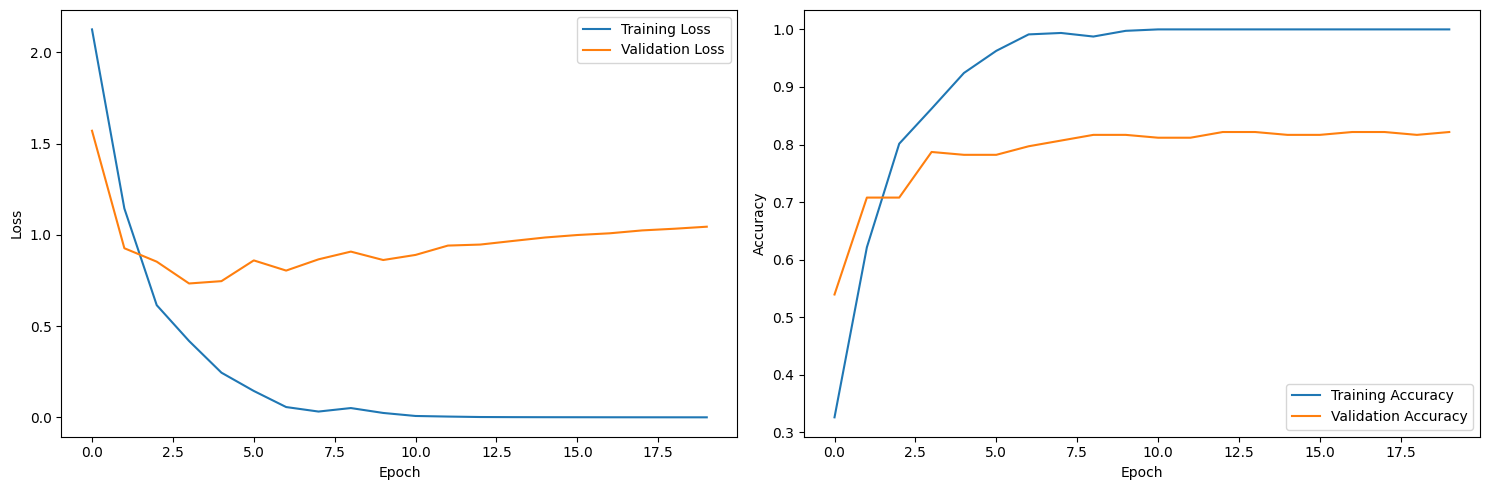

In [ ]:
import matplotlib.pyplot as plt

# Create a 1x2 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and validation loss on the first subplot
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot training and validation accuracy on the second subplot
axes[1].plot(history.history['accuracy'], label='Training Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test data
# test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)

# Obtain final epoch training and testing accuracy
final_train_accuracy = history.history['accuracy'][-1]
final_test_accuracy = history.history['val_accuracy'][-1]

# Print the final epoch training and testing accuracy
print("Training Accuracy:{:.4f}".format(final_train_accuracy))
print("Val Accuracy:{:.4f}".format(final_test_accuracy))



Training Accuracy:1.0000
Val Accuracy:0.8218


In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=batch_size)

# Print test accuracy
print("Test Accuracy:", test_accuracy)

14/14 [==============================] - 1s 59ms/step - loss: 1.2234 - accuracy: 0.7917
Test Accuracy: 0.7916666865348816


# Testing



In [ ]:
# Assuming you have a new audio file for prediction
new_audio_file = "/content/drive/MyDrive/archive/Training/Bdim/Bdim_AcusticPlug10_4.wav"

# Extract MFCCs from the new audio file
new_mfccs = extract_mfcc(new_audio_file, n_mfcc)
if new_mfccs.shape[1] < time_steps:
    new_mfccs_padded = np.pad(new_mfccs, ((0, 0), (0, time_steps - new_mfccs.shape[1])))
else:
    new_mfccs_padded = new_mfccs[:, :time_steps]

# Reshape the input data for the model (add a channel dimension)
input_data = new_mfccs_padded.reshape(1, n_mfcc, time_steps, 1)

# Make prediction
prediction = model.predict(input_data)
predicted_chord_index = np.argmax(prediction)
predicted_chord = chords[predicted_chord_index]

# Format probabilities as percentages
np.set_printoptions(formatter={'float': '{:0.2f}'.format})
probabilities_percentage = prediction * 100

print("Predicted Chord:", predicted_chord)
print("Chord\t\tProbability")
for i in range(len(chords)):
    chord_name = chords[i]
    probability = probabilities_percentage[0][i]
    print(f"{chord_name}\t\t{probability:.2f}%")

1/1 [==============================] - 0s 109ms/step
Predicted Chord: Bdim
Chord		Probability
Am		0.00%
Bb		0.00%
Bdim		100.00%
C		0.00%
Dm		0.00%
Em		0.00%
F		0.00%
G		0.00%


# Detect Multiple chords

In [ ]:
# "/content/drive/MyDrive/com2.wav"

In [ ]:
from IPython.display import Audio
Audio("/content/drive/MyDrive/com2.wav")

In [ ]:
import librosa
import soundfile as sf
import tempfile
import os

# Load the audio file
audio_file_path = "/content/drive/MyDrive/com2.wav"
audio_data, sr = librosa.load(audio_file_path, sr=22050)

# Detect chord segments using onset detection
onsets = librosa.onset.onset_detect(y=audio_data, sr=sr)
start_times = librosa.frames_to_time(onsets, sr=sr)

end_times = start_times[1:].tolist() + [librosa.get_duration(y=audio_data, sr=sr)]

# Initialize a list to store the chord predictions
chord_predictions = []

# Loop over each chord segment
for start_time, end_time in zip(start_times, end_times):
    # Extract the segment audio data
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    segment_audio = audio_data[start_sample:end_sample]

    # Save the audio segment as a temporary file
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp_file:
        tmp_audio_path = tmp_file.name
        sf.write(tmp_audio_path, segment_audio, sr)

        # Extract MFCCs from the temporary audio file
        n_mfcc = 20
        mfccs = extract_mfcc(tmp_audio_path, n_mfcc)

        # Pad or truncate the MFCCs to the fixed time_steps
        time_steps = 500
        if mfccs.shape[1] < time_steps:
            mfccs_padded = np.pad(mfccs, ((0, 0), (0, time_steps - mfccs.shape[1])))
        else:
            mfccs_padded = mfccs[:, :time_steps]

        # Reshape the input data for the model (add a channel dimension)
        input_data = mfccs_padded.reshape(1, n_mfcc, time_steps, 1)

        # Make prediction
        prediction = model.predict(input_data)

        # Get the predicted chord index
        predicted_chord_index = np.argmax(prediction)

        # Get the predicted chord label
        predicted_chord = chords[predicted_chord_index]

        # Append the predicted chord label and segment times to the list
        chord_predictions.append((predicted_chord, start_time, end_time))

        # Delete the temporary audio file
        os.remove(tmp_audio_path)

# Print the chord predictions
for chord, start_time, end_time in chord_predictions:
    print("Chord:", chord, "Start Time:", start_time, "End Time:", end_time)
    print()


1/1 [==============================] - 0s 70ms/step
Chord: F Start Time: 0.09287981859410431 End Time: 0.2089795918367347

Chord: G Start Time: 0.2089795918367347 End Time: 3.877732426303855

Chord: F Start Time: 3.877732426303855 End Time: 4.017052154195011

Chord: F Start Time: 4.017052154195011 End Time: 4.156371882086168

Chord: F Start Time: 4.156371882086168 End Time: 4.295691609977324

Chord: F Start Time: 4.295691609977324 End Time: 4.435011337868481

Chord: F Start Time: 4.435011337868481 End Time: 7.291065759637188

Chord: F Start Time: 7.291065759637188 End Time: 7.430385487528345

Chord: C Start Time: 7.430385487528345 End Time: 11.377777777777778

Chord: F Start Time: 11.377777777777778 End Time: 11.517097505668934

Chord: F Start Time: 11.517097505668934 End Time: 11.679637188208616

Chord: Bb Start Time: 11.679637188208616 End Time: 14.907210884353741

Chord: Bdim Start Time: 14.907210884353741 End Time: 15.09297052154195

Chord: Am Start Time: 15.09297052154195 End Time

# Beat

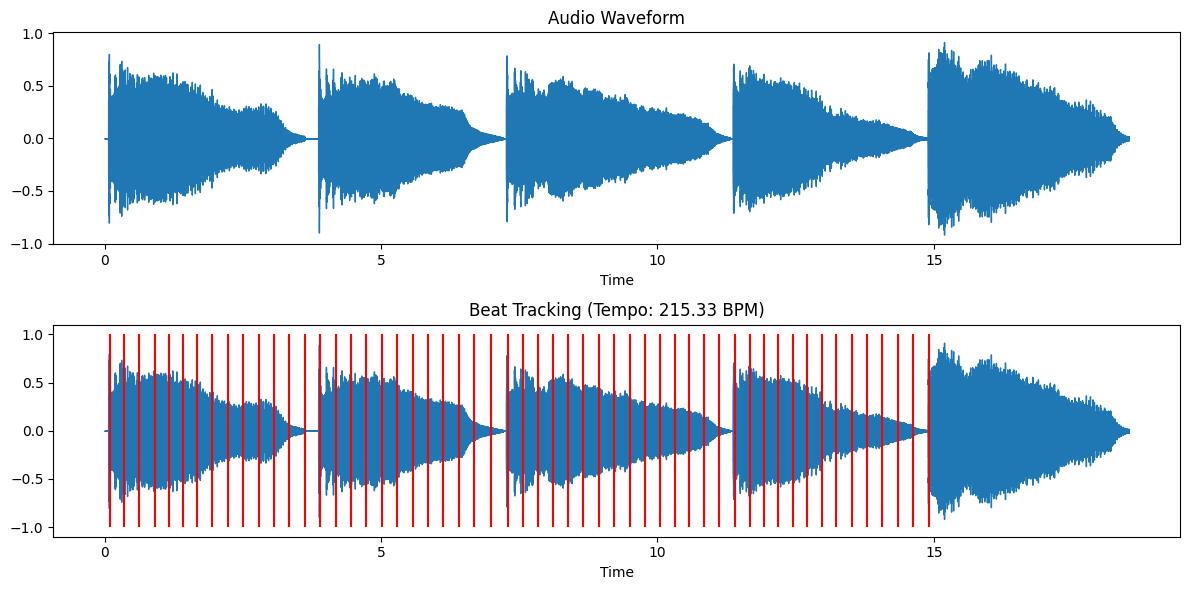

In [ ]:
# Load audio file
audio_file = '/content/drive/MyDrive/com2.wav'
y, sr = librosa.load(audio_file)

# Beat tracking
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

# Convert beat frames to time (seconds)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

# Plot the waveform
plt.figure(figsize=(12, 6))

# Subplot 1: Waveform
plt.subplot(2, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title('Audio Waveform')

# Subplot 2: Beats
plt.subplot(2, 1, 2)
librosa.display.waveshow(y, sr=sr)
plt.vlines(beat_times, -1, 1, color='r', linestyle='-', label='Beats')
plt.title(f'Beat Tracking (Tempo: {tempo:.2f} BPM)')

plt.tight_layout()
plt.show()

In [ ]:
# Load audio file
audio_file = '/content/drive/MyDrive/com2.wav'
y, sr = librosa.load(audio_file)

# Beat tracking
tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

print(f'Tempo: {tempo:.2f} BPM')

Tempo: 215.33 BPM


## saving

In [ ]:
!pip install pygame pydub


In [ ]:
from IPython.display import Audio
Audio("/content/drive/MyDrive/com2.wav")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Save the trained model
model.save('chord_detection_model.h5')
